In [41]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = estimator.fit_transform(X_transformed, y)
        # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [43]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
        # fit the last step
    return self.steps[-1][1].predict(X_transformed)

In [44]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [45]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0
)
scaler = MinMaxScaler().fit(X_train)

In [46]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)
svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.97


In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'C': 1, 'gamma': 1}


In [48]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

The syntax to define a parameter grid for a pipeline is to specify for each parameter the step name, followed by __ (a double underscore), followed by the parameter name.

In [49]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [50]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


In [51]:
param_grid = {
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "svm__gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}

In [52]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


Because we fit the feature selection outside of the cross-validation, it could find features that are correlated both on the training and the test folds.

In [53]:
import numpy as np

rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [54]:
from sklearn.feature_selection import SelectPercentile, f_regression

# select the most informative of the 10 features using SelectPercentile feature selection,
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print(
    "Cross-validation accuracy (cv only on ridge): {:.2f}".format(
        np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))
    )
)

Cross-validation accuracy (cv only on ridge): 0.91


In [56]:
pipe = Pipeline(
    [
        ("select", SelectPercentile(score_func=f_regression, percentile=5)),
        ("ridge", Ridge()),
    ]
)
print(
    "Cross-validation accuracy (pipeline): {:.2f}".format(
        np.mean(cross_val_score(pipe, X, y, cv=5))
    )
)

Cross-validation accuracy (pipeline): -0.25


In [59]:
from sklearn.pipeline import make_pipeline

# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [60]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


In [62]:
# fit the pipeline defined before to the cancer dataset
pipe.fit(cancer.data)
# extract the first two principal components from the "pca" step
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


In [63]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [64]:
param_grid = {"logisticregression__C": [0.01, 0.1, 1, 10, 100]}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4
)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

In [66]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])


In [67]:
print(
    "Logistic regression step:\n{}".format(
        grid.best_estimator_.named_steps["logisticregression"]
    )
)

Logistic regression step:
LogisticRegression(C=1)


In [68]:
print(
    "Logistic regression coefficients:\n{}".format(
        grid.best_estimator_.named_steps["logisticregression"].coef_
    )
)

Logistic regression coefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


In [ ]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0
)
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [70]:
param_grid = {
    "polynomialfeatures__degree": [1, 2, 3],
    "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100],
}

In [71]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

array([ 7.21915761e-01,  7.21919281e-01,  7.21954085e-01,  7.22265610e-01,
        7.23325945e-01,  7.07951636e-01,  7.60170834e-01,  7.59448408e-01,
        7.66651449e-01,  7.94966818e-01,  8.28726141e-01,  8.04832665e-01,
       -5.81095202e+02, -1.60898751e+02, -1.31972858e+01, -3.17933469e-02,
        6.48340571e-01,  6.54083028e-01])

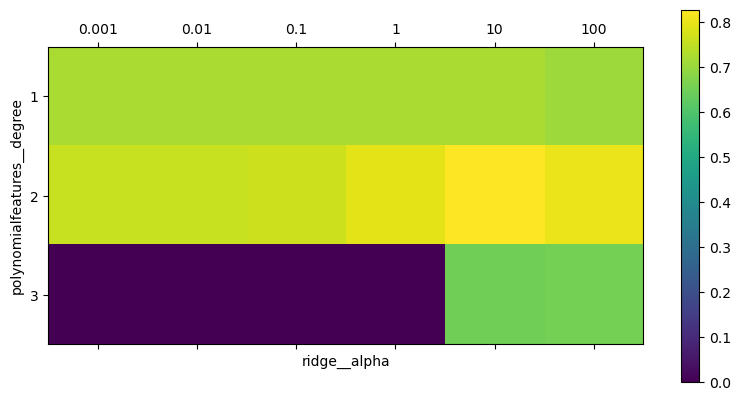

In [83]:
import matplotlib.pyplot as plt

plt.matshow(grid.cv_results_["mean_test_score"].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid["ridge__alpha"])), param_grid["ridge__alpha"])
plt.yticks(
    range(len(param_grid["polynomialfeatures__degree"])),
    param_grid["polynomialfeatures__degree"],
)
plt.colorbar()
grid.cv_results_["mean_test_score"]

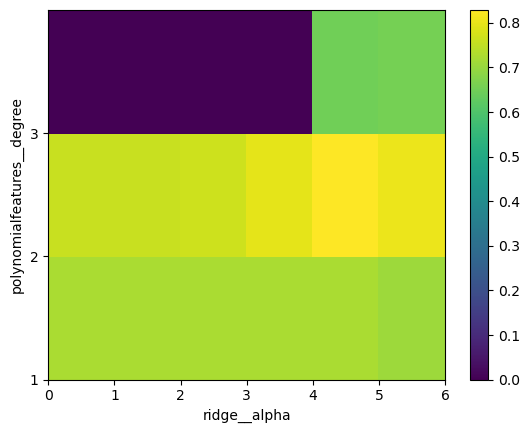

In [84]:
plt.pcolor(grid.cv_results_["mean_test_score"].reshape(3, -1), vmin=0, cmap="viridis")
plt.yticks(range(3), range(1, 4))
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.colorbar()

In [85]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [86]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [87]:
param_grid = {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


In [88]:
pipe = Pipeline([("preprocessing", StandardScaler()), ("classifier", SVC())])

In [89]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {
        "classifier": [SVC()],
        "preprocessing": [StandardScaler(), None],
        "classifier__gamma": [0.001, 0.01, 0.1, 1, 10, 100],
        "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100],
    },
    {
        "classifier": [RandomForestClassifier(n_estimators=100)],
        "preprocessing": [None],
        "classifier__max_features": [1, 2, 3],
    },
]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0
)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.99
Test-set score: 0.98
